# Fashion Product Image Classification – Full Example

In this notebook I put everything together for the project:

1. Load the Fashion Product Images (Small) dataset from Kaggle (TSV lists + images).
2. Apply basic data augmentation on the training set.
3. Train a simple CNN baseline using my helper API (`make_baseline_cnn`).
4. Train a transfer learning model based on a pre-trained ImageNet network (e.g., MobileNetV2).
5. Run an AutoKeras `ImageClassifier` search on a subset of the data.
6. Evaluate all models with accuracy, precision, recall, and F1-score.
7. Visualize misclassified images and compare the three approaches.

This notebook is meant to be run inside Docker, after copying the Kaggle images
into the local `images/` directory as described in `data_readme.md`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

from src.utils_data_io import tsv_to_tfds, ds_to_numpy
from src.utils_model import make_baseline_cnn, make_autokeras_image_classifier

# Reduce TF log noise a bit (optional)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("TensorFlow version:", tf.__version__)

CLASS_NAMES = [
    "Accessories",
    "Apparel",
    "Footwear",
    "Free Items",
    "Personal Care",
    "Sporting Goods",
]
NUM_CLASSES = len(CLASS_NAMES)

TRAIN_TSV = "lists/train.tsv"
VAL_TSV   = "lists/val.tsv"
TEST_TSV  = "lists/test.tsv"

os.makedirs("outputs", exist_ok=True)
os.makedirs("models", exist_ok=True)

2025-12-10 05:48:47.320630: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-10 05:48:47.345868: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 05:48:48.202990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 05:48:50.760569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

TensorFlow version: 2.20.0


Load tf.data datasets

In [2]:
# Load the train/val/test splits from the TSV lists.
train_ds_raw = tsv_to_tfds(TRAIN_TSV, num_classes=NUM_CLASSES)
val_ds_raw   = tsv_to_tfds(VAL_TSV,   num_classes=NUM_CLASSES)
test_ds_raw  = tsv_to_tfds(TEST_TSV,  num_classes=NUM_CLASSES)

train_ds_raw, val_ds_raw, test_ds_raw

2025-12-10 05:48:52.589702: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>)

Data augmentation & batching

In [3]:
# I keep augmentation pretty simple on purpose.
# The goal is to make the model a bit more robust without overcomplicating the pipeline.

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    # Random 0–3 rotations of 90 degrees
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    return image, label

BATCH_SIZE = 32

train_ds = (
    train_ds_raw
    .shuffle(5000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds_raw
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds_raw
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

train_ds, val_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

Prepare NumPy subsets for baseline CNN

In [4]:
# For the baseline CNN, I keep a moderate subset so that it trains
# in a reasonable time on CPU inside the Docker container.

MAX_TRAIN = 2000
MAX_VAL   = 500
MAX_TEST  = 500

X_train, y_train = ds_to_numpy(train_ds_raw, max_samples=MAX_TRAIN)
X_val,   y_val   = ds_to_numpy(val_ds_raw,   max_samples=MAX_VAL)
X_test,  y_test  = ds_to_numpy(test_ds_raw,  max_samples=MAX_TEST)

X_train.shape, X_val.shape, X_test.shape

((2000, 224, 224, 3), (500, 224, 224, 3), (500, 224, 224, 3))

Build baseline CNN

In [5]:
baseline_model = make_baseline_cnn(
    input_shape=X_train.shape[1:],
    num_classes=NUM_CLASSES,
)

baseline_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,158 (98.36 MB)

 Trainable params: 25,785,158 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

Train baseline CNN

In [6]:
EPOCHS_BASELINE = 5
BATCH_SIZE_BASELINE = 32

history_baseline = baseline_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_BASELINE,
    batch_size=BATCH_SIZE_BASELINE,
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 764ms/step - accuracy: 0.7255 - loss: 1.0913 - val_accuracy: 0.9060 - val_loss: 0.3963
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 619ms/step - accuracy: 0.9015 - loss: 0.3378 - val_accuracy: 0.9220 - val_loss: 0.2532
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 625ms/step - accuracy: 0.9330 - loss: 0.2195 - val_accuracy: 0.9340 - val_loss: 0.2069
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 625ms/step - accuracy: 0.9430 - loss: 0.1742 - val_accuracy: 0.9260 - val_loss: 0.2183
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - accuracy: 0.9525 - loss: 0.1436 - val_accuracy: 0.9220 - val_loss: 0.2498


Evaluate baseline & save outputs

In [7]:
# Predict on test set
y_probs = baseline_model.predict(X_test)
y_pred  = np.argmax(y_probs, axis=1)

labels = list(range(NUM_CLASSES))

report_baseline = classification_report(
    y_test,
    y_pred,
    labels=labels,
    target_names=CLASS_NAMES,
    zero_division=0,
)

print(report_baseline)

with open("outputs/report_baseline.txt", "w") as f:
    f.write(report_baseline)

cm_baseline = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6, 6))
plt.imshow(cm_baseline, cmap="Blues")
plt.title("Confusion Matrix - Baseline CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("outputs/confmat_baseline.png")
plt.close()

print("Baseline outputs saved:")
print(" - outputs/report_baseline.txt")
print(" - outputs/confmat_baseline.png")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step
                precision    recall  f1-score   support

   Accessories       0.91      0.75      0.82       137
       Apparel       0.85      0.99      0.92       241
      Footwear       0.98      0.92      0.95        97
    Free Items       0.00      0.00      0.00         3
 Personal Care       0.94      0.68      0.79        22
Sporting Goods       0.00      0.00      0.00         0

      accuracy                           0.89       500
     macro avg       0.61      0.56      0.58       500
  weighted avg       0.89      0.89      0.89       500

Baseline outputs saved:
 - outputs/report_baseline.txt
 - outputs/confmat_baseline.png


Build MobileNetV2 model

In [8]:
from tensorflow.keras.applications import MobileNetV2

# For transfer learning, I use a standard MobileNetV2 backbone pre-trained on ImageNet.
# I keep the architecture pretty simple: global average pooling + dropout + final Dense.

IMG_SIZE = (224, 224)

base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
)

# For the first pass, I freeze the base model so only the new classification head trains.
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)  # MobileNet expects inputs roughly in [0, 1]
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

mobilenet_model = tf.keras.Model(inputs, outputs)

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train MobileNetV2

In [9]:
# I keep the number of epochs small inside Docker so training is still reasonable on CPU.
# Later, I can re-run this on Colab Pro with more epochs and possibly unfreeze some layers.

EPOCHS_MOBILENET = 3

history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_MOBILENET,
)

Epoch 1/3
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 592s 519ms/step - accuracy: 0.9226 - loss: 0.2399 - val_accuracy: 0.9714 - val_loss: 0.1084
Epoch 2/3
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 505s 451ms/step - accuracy: 0.9507 - loss: 0.1597 - val_accuracy: 0.9725 - val_loss: 0.0973
Epoch 3/3
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 513s 458ms/step - accuracy: 0.9545 - loss: 0.1484 - val_accuracy: 0.9750 - val_loss: 0.0971


Helper to get predictions from a tf.data.Dataset

In [10]:
# For evaluation I want a small helper that takes a model and a tf.data.Dataset
# and returns flat NumPy arrays of y_true and y_pred.

def predict_on_dataset(model, dataset):
    y_true_list = []
    y_pred_list = []

    for batch_x, batch_y in dataset:
        probs = model.predict(batch_x, verbose=0)
        preds = np.argmax(probs, axis=1)
        y_true_list.append(batch_y.numpy())
        y_pred_list.append(preds)

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    return y_true, y_pred

Evaluate MobileNetV2 & save outputs

In [11]:
# Evaluate MobileNetV2 on the test set using the helper.

y_true_mn, y_pred_mn = predict_on_dataset(mobilenet_model, test_ds)

labels = list(range(NUM_CLASSES))

report_mobilenet = classification_report(
    y_true_mn,
    y_pred_mn,
    labels=labels,
    target_names=CLASS_NAMES,
    zero_division=0,
)

print(report_mobilenet)

with open("outputs/report_mobilenet.txt", "w") as f:
    f.write(report_mobilenet)

cm_mobilenet = confusion_matrix(y_true_mn, y_pred_mn, labels=labels)

plt.figure(figsize=(6, 6))
plt.imshow(cm_mobilenet, cmap="Blues")
plt.title("Confusion Matrix - MobileNetV2 (transfer learning)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("outputs/confmat_mobilenet.png")
plt.close()

# I also save the trained model so I can reuse it without retraining if needed.
mobilenet_model.save("models/mobilenetv2_fashion.keras")

print("MobileNetV2 outputs saved:")
print(" - outputs/report_mobilenet.txt")
print(" - outputs/confmat_mobilenet.png")
print(" - models/mobilenetv2_fashion.keras")

2025-12-10 06:21:35.281991: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                precision    recall  f1-score   support

   Accessories       0.96      0.94      0.95      1127
       Apparel       0.97      0.99      0.98      2139
      Footwear       0.99      1.00      1.00       922
    Free Items       0.00      0.00      0.00        11
 Personal Care       0.96      0.91      0.94       240
Sporting Goods       1.00      0.33      0.50         3

      accuracy                           0.97      4442
     macro avg       0.81      0.70      0.73      4442
  weighted avg       0.97      0.97      0.97      4442

MobileNetV2 outputs saved:
 - outputs/report_mobilenet.txt
 - outputs/confmat_mobilenet.png
 - models/mobilenetv2_fashion.keras


NumPy subsets for AutoKeras

In [12]:
# --- AutoKeras: prepare smaller NumPy subsets for the search ---

# Docker run: keep this very small to avoid killing the kernel.
# I use only 200 train and 50 validation examples here.

AK_MAX_TRAIN = 200
AK_MAX_VAL   = 50

X_ak_train = X_train[:AK_MAX_TRAIN]
y_ak_train = y_train[:AK_MAX_TRAIN]

X_ak_val = X_val[:AK_MAX_VAL]
y_ak_val = y_val[:AK_MAX_VAL]

X_ak_train.shape, X_ak_val.shape

((200, 224, 224, 3), (50, 224, 224, 3))

Create AutoKeras classifier

In [13]:
# --- Create the AutoKeras ImageClassifier via my helper API ---

try:
    MAX_TRIALS_AK = 1   
    EPOCHS_AK     = 1   

    ak_clf = make_autokeras_image_classifier(
        num_classes=NUM_CLASSES,
        max_trials=MAX_TRIALS_AK,
    )

    print("AutoKeras classifier created.")
    print("max_trials:", MAX_TRIALS_AK, "| epochs per trial:", EPOCHS_AK)
except Exception as e:
    print("Could not create AutoKeras classifier. Error:")
    print(e)
    ak_clf = None

AutoKeras classifier created.
max_trials: 1 | epochs per trial: 1


call fit with NumPy arrays

In [14]:
# --- Run a tiny AutoKeras search on the NumPy subset (Docker demo only) ---

if ak_clf is not None:
    ak_clf.fit(
        X_ak_train,
        y_ak_train,
        epochs=EPOCHS_AK,
        validation_data=(X_ak_val, y_ak_val),
    )

    # Export the best model found by AutoKeras.
    ak_best_model = ak_clf.export_model()
else:
    ak_best_model = None

Trial 1 Complete [00h 00m 34s]
val_loss: 1.8474918603897095

Best val_loss So Far: 1.8474918603897095
Total elapsed time: 00h 00m 34s
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5050 - loss: 9.7969 - val_accuracy: 0.7000 - val_loss: 4.5692


/usr/local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluate AutoKeras best model & save outputs

In [15]:
# --- Evaluate the best AutoKeras model and save outputs ---

if ak_best_model is not None:
    # It’s safer to recompile the exported model before evaluation.
    ak_best_model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Reuse the helper I wrote earlier for tf.data datasets.
    y_true_ak, y_pred_ak = predict_on_dataset(ak_best_model, test_ds)

    labels = list(range(NUM_CLASSES))

    report_autokeras = classification_report(
        y_true_ak,
        y_pred_ak,
        labels=labels,
        target_names=CLASS_NAMES,
        zero_division=0,
    )

    print(report_autokeras)

    with open("outputs/report_autokeras.txt", "w") as f:
        f.write(report_autokeras)

    cm_autokeras = confusion_matrix(y_true_ak, y_pred_ak, labels=labels)

    plt.figure(figsize=(6, 6))
    plt.imshow(cm_autokeras, cmap="Blues")
    plt.title("Confusion Matrix - AutoKeras (Docker subset)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig("outputs/confmat_autokeras.png")
    plt.close()

    # Save the exported model so I can reuse it if needed.
    ak_best_model.save("models/autokeras_best_docker.keras")

    print("AutoKeras outputs saved:")
    print(" - outputs/report_autokeras.txt")
    print(" - outputs/confmat_autokeras.png")
    print(" - models/autokeras_best_docker.keras")
else:
    print("Skipping AutoKeras evaluation because no model was exported.")

2025-12-10 06:23:29.775004: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                precision    recall  f1-score   support

   Accessories       0.61      0.51      0.56      1127
       Apparel       0.84      0.90      0.87      2139
      Footwear       0.76      0.99      0.86       922
    Free Items       0.00      0.00      0.00        11
 Personal Care       0.00      0.00      0.00       240
Sporting Goods       0.00      0.00      0.00         3

      accuracy                           0.77      4442
     macro avg       0.37      0.40      0.38      4442
  weighted avg       0.72      0.77      0.74      4442

AutoKeras outputs saved:
 - outputs/report_autokeras.txt
 - outputs/confmat_autokeras.png
 - models/autokeras_best_docker.keras


Get predictions from all three models on the same X_test

In [16]:
# --- Collect predictions from all three models on the same NumPy test set ---

# Baseline predictions on X_test
y_probs_baseline = baseline_model.predict(X_test)
y_pred_baseline  = np.argmax(y_probs_baseline, axis=1)

# MobileNetV2 predictions on X_test
y_probs_mn   = mobilenet_model.predict(X_test)
y_pred_mn_np = np.argmax(y_probs_mn, axis=1)

# AutoKeras predictions on X_test
ak_best_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

y_probs_ak   = ak_best_model.predict(X_test)
y_pred_ak_np = np.argmax(y_probs_ak, axis=1)

y_pred_baseline.shape, y_pred_mn_np.shape, y_pred_ak_np.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step


((500,), (500,), (500,))

Helper to plot misclassified examples

In [17]:
import random

def show_misclassified_examples(
    X,
    y_true,
    y_pred,
    class_names,
    model_name,
    n_examples=9,
):
    mis_idx = np.where(y_true != y_pred)[0]

    if len(mis_idx) == 0:
        print(f"{model_name}: no misclassified examples in this sample.")
        return

    n_examples = min(n_examples, len(mis_idx))
    chosen_idx = random.sample(list(mis_idx), n_examples)

    rows = 3
    cols = (n_examples + rows - 1) // rows

    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, idx in enumerate(chosen_idx):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X[idx].astype("uint8"))
        plt.axis("off")
        true_label = class_names[int(y_true[idx])]
        pred_label = class_names[int(y_pred[idx])]
        plt.title(f"T: {true_label}\nP: {pred_label}")

    plt.suptitle(f"Misclassified examples – {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

Visualize misclassified examples for each model

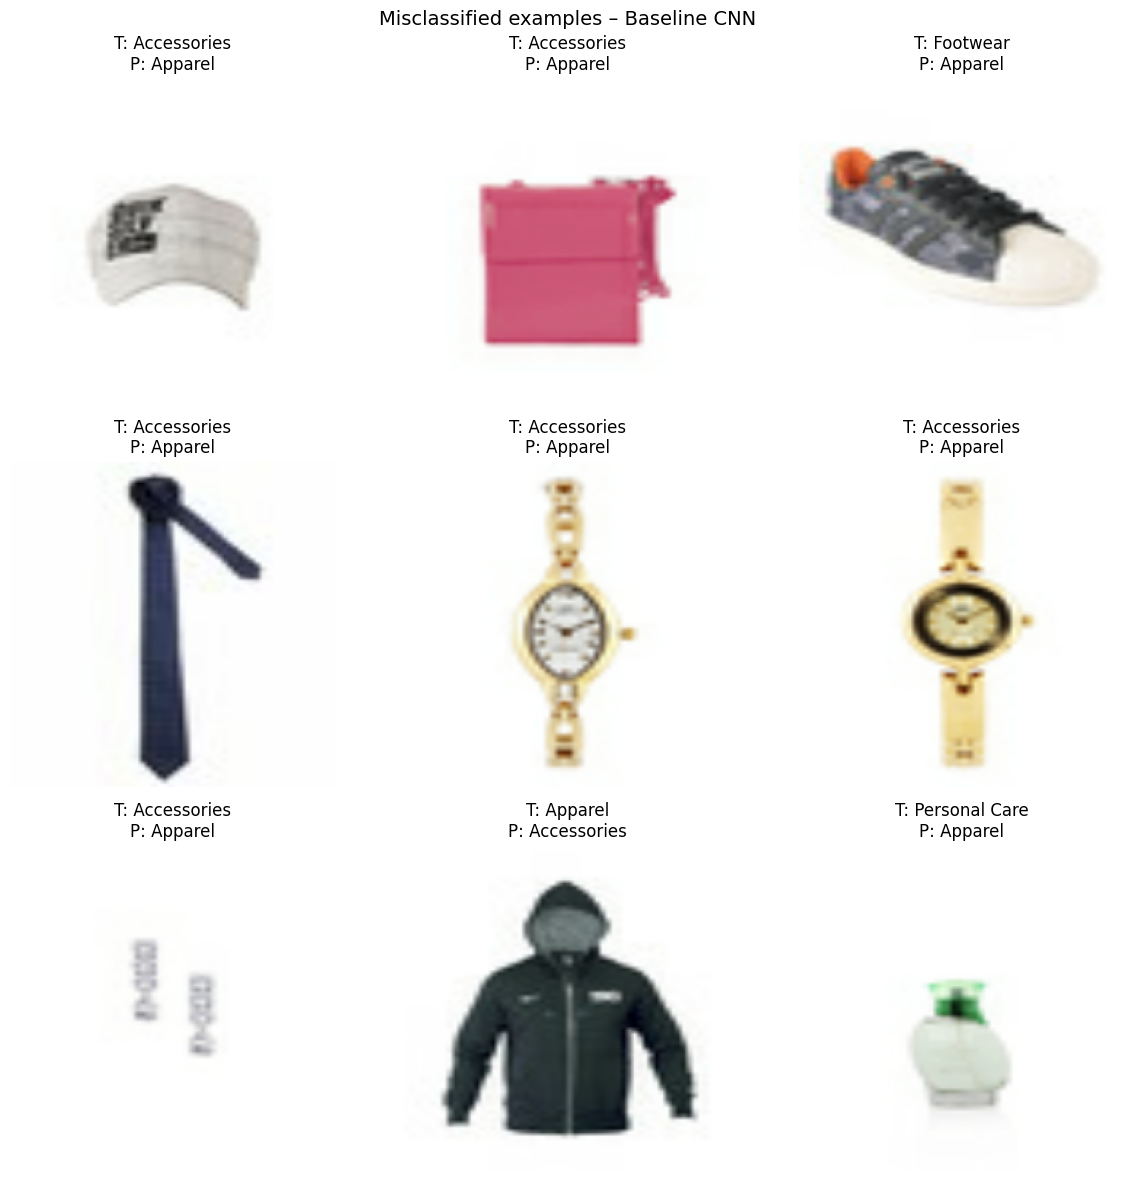

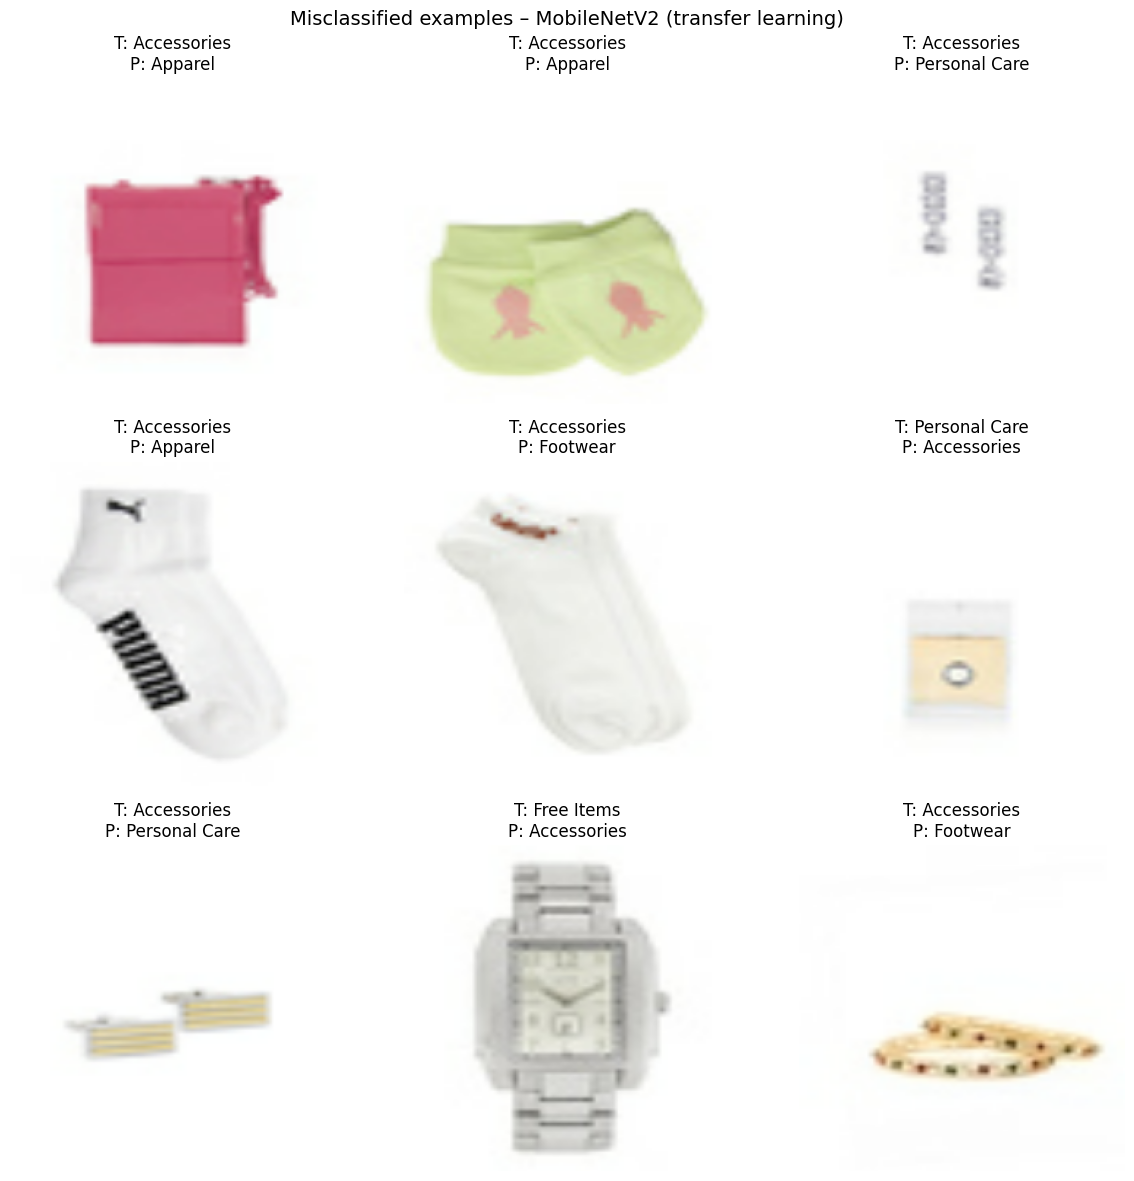

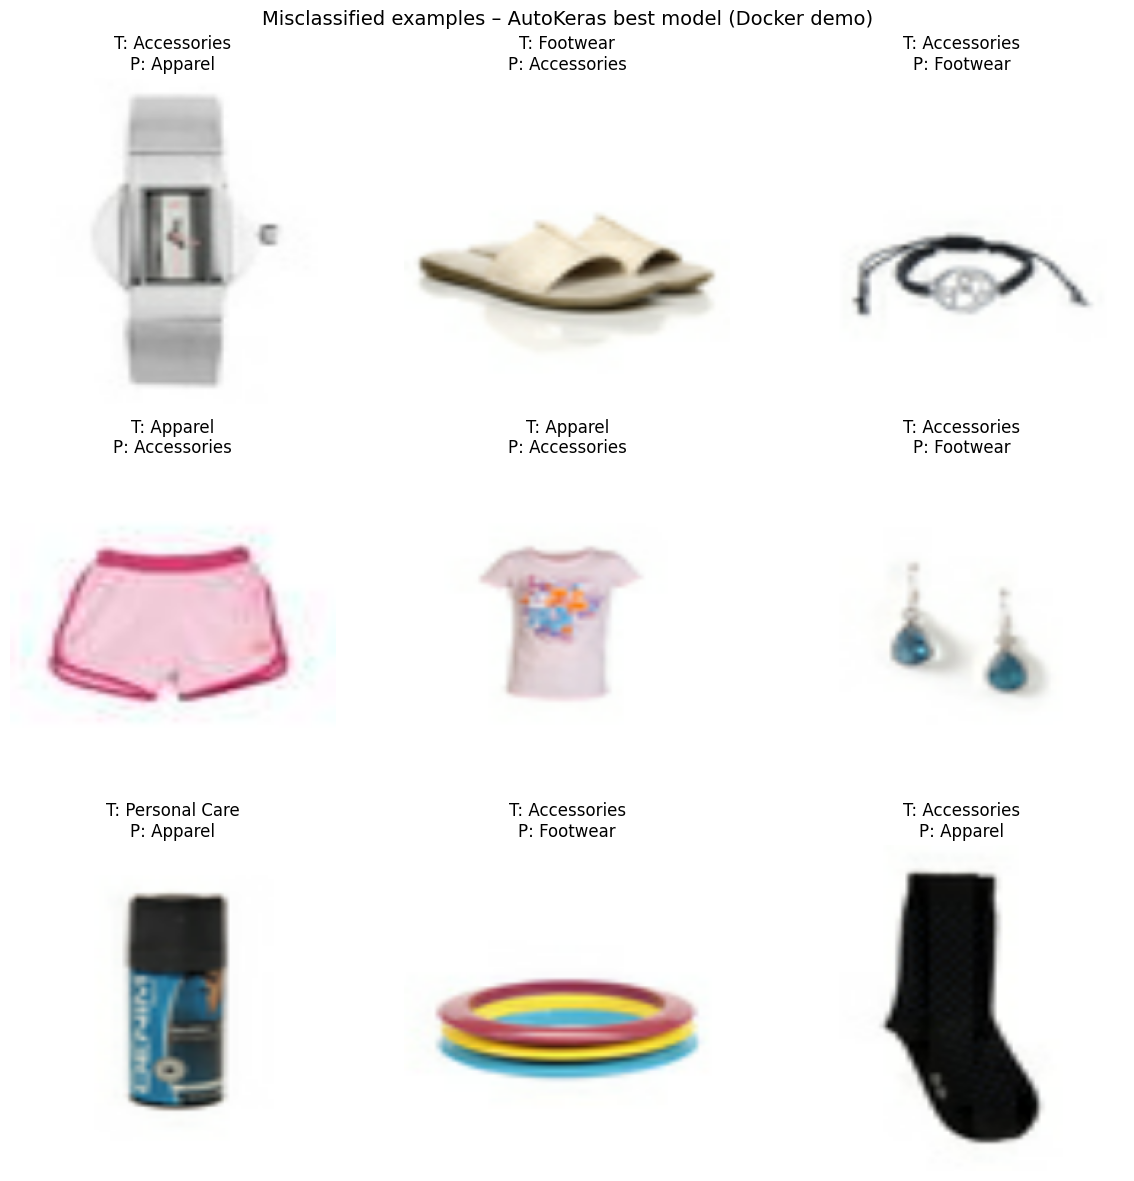

In [18]:
# Baseline CNN misclassifications
show_misclassified_examples(
    X=X_test,
    y_true=y_test,
    y_pred=y_pred_baseline,
    class_names=CLASS_NAMES,
    model_name="Baseline CNN",
    n_examples=9,
)

# MobileNetV2 misclassifications
show_misclassified_examples(
    X=X_test,
    y_true=y_test,
    y_pred=y_pred_mn_np,
    class_names=CLASS_NAMES,
    model_name="MobileNetV2 (transfer learning)",
    n_examples=9,
)

# AutoKeras best model misclassifications
show_misclassified_examples(
    X=X_test,
    y_true=y_test,
    y_pred=y_pred_ak_np,
    class_names=CLASS_NAMES,
    model_name="AutoKeras best model (Docker demo)",
    n_examples=9,
)

### Summary (Docker example vs. full Colab run)

In this Docker notebook I keep the pipeline lightweight so it runs reliably on CPU:

- **Baseline CNN** – rained on a subset (2,000 train / 500 val / 500 test) for 5 epochs.  
- **MobileNetV2** – trained on the full tf.data pipeline, but only for 3 epochs.
- **AutoKeras** – limited to max_trials=1 and epochs=1 on a small NumPy subset, just to show that the search pipeline works.

The full experiment — with larger subsets, more epochs, data augmentation, and a deeper AutoKeras search (max_trials=9) — is run in Autokeras.full_training.ipynb on GPU in Colab.